<center><h1>Hu_Evan_Final_Project</h1></center>

Name: Evan Hu
<br>
Github Username: evanhu-ds
<br>
USC ID: 4349471794

# Transfer Learning for Image Classification

In this project, we build a classifier that distinguishes images of 17 types of jute pest. Images are divided into training, validation, and test sets by folder directory. 

Image data folder structure:


Jute_Pest_Dataset/
<br>
├── train/
<br>
│   ├──── class1/
<br>
│   ├──── class2/
<br>
├── val/
<br>
│   ├──── class1/
<br>
│   ├──── class2/
<br>
├── test/
<br>
│   ├──── class1/
<br>
│   ├──── class2/



In [53]:
# Import packages
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import cv2
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random
import shutil
import pandas as pd

2025-12-14 16:27:12.146577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Exploration and Pre-processing

In [3]:
random.seed(42)
data_path = "../data/Jute_Pest_Dataset"

train_path = "../data/Jute_Pest_Dataset/train"
val_path = "../data/Jute_Pest_Dataset/val"
test_path = "../data/Jute_Pest_Dataset/test"

classes = os.listdir(train_path)
print(f"Number of classes: {len(classes)}")
print("--- Class names: ----")
for cls in classes:
    print(cls)

Number of classes: 17
--- Class names: ----
Field Cricket
Termite odontotermes (Rambur)
Leaf Beetle
Jute Aphid
Jute Red Mite
Cutworm
Yellow Mite
Mealybug
Black Hairy
Jute Semilooper
Beet Armyworm
Jute Hairy
Jute Stem Weevil
Scopula Emissaria
Jute Stem Girdler
Termite
Pod Borer


In [4]:
train_sum = 0
train_dir = os.listdir(train_path)
for cls in train_dir:
    train_sum += len(os.listdir(os.path.join(train_path, cls)))
    #print(cls, ":", len(os.listdir(os.path.join(train_path, cls))))
print(f"Training set size: {train_sum} samples")

val_sum = 0
val_dir = os.listdir(val_path)
for cls in val_dir:
    val_sum += len(os.listdir(os.path.join(val_path, cls)))
    #print(cls, ":", len(os.listdir(os.path.join(val_path, cls))))
print(f"Validation set size: {val_sum} samples")

test_sum = 0
test_dir = os.listdir(test_path)
for cls in test_dir:
    test_sum += len(os.listdir(os.path.join(test_path, cls)))
    #print(cls, ":", len(os.listdir(os.path.join(test_path, cls))))
print(f"Test set size: {test_sum} samples")

Training set size: 6444 samples
Validation set size: 413 samples
Test set size: 379 samples


In [5]:
# Initialize certain parameters
IMG_SIZE = (224, 224)    # common input size for transfer learning
BATCH_SIZE = 5
EPOCHS = 100
L2_REG = 1e-4
DROPOUT_RATE = 0.20
PATIENCE = 50  # early stopping parameter but set to 50 to ensure at least 50 epochs during training

The images in the dataset have varying spatial resolutions. To ensure a uniform input size for transfer learning models, each image will be zero-padded to a square shape and then resized to 224×224 pixels. This preprocessing step preserves aspect ratios while enabling compatibility with pre-trained ImageNet models.

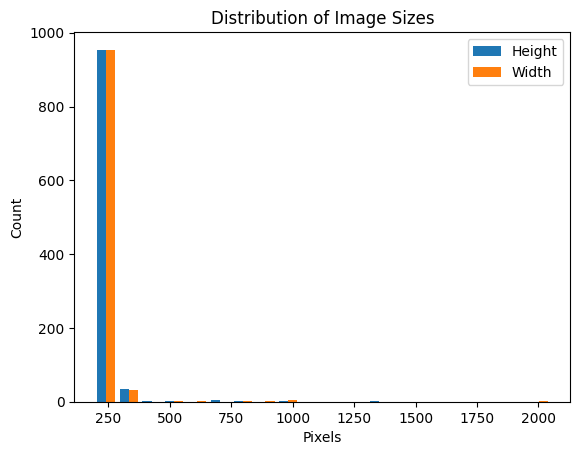

Biggest Image Size from Sample: (1365, 2048)
Smallest Image Size from Sample: (194, 259)
Most Common Image Size from Sample: (256, 256)


In [6]:
def sample_image_shapes(dir_path, max_images=1000):
    shapes = []
    count = 0
    for split in ["train", "val", "test"]:
        split_path = os.path.join(dir_path, split)
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                shapes.append(img.shape[:2])  # (H, W)
                count += 1
                if count >= max_images:
                    return shapes
    return shapes

shapes = sample_image_shapes(data_path)

heights = [s[0] for s in shapes]
widths  = [s[1] for s in shapes]

plt.hist(
    [heights, widths],
    bins=20,
    label=["Height", "Width"]
)

plt.legend()
plt.title("Distribution of Image Sizes")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

print(f"Biggest Image Size from Sample: {max(shapes)}")
print(f"Smallest Image Size from Sample: {min(shapes)}")
print(f"Most Common Image Size from Sample: {statistics.mode(shapes)}")

From the results of the cell block above, we sampled images from our dataset, and the majority of images are 256x256 with the biggest image size as 1365x2048 and the smallest image size as 194x259. The following two code cells will zero-pad the images to square-shapes and then resize them to 224x224 pixels using OpenCV. The pre-processed images will be saved into a new folder directory `../data/Jute_Pest_Processed` that has the same structure as `../data/Jute_Pest_Dataset`.

In [8]:
def pad_to_square(img):
    h, w = img.shape[:2]
    size = max(h, w)

    padded_img = np.zeros((size, size, 3), dtype=np.uint8)

    y_offset = (size - h) // 2
    x_offset = (size - w) // 2

    padded_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
    return padded_img

def preprocess_data(input_dir, output_dir, target_size=IMG_SIZE):
    '''
    - zero-pad images to square size --> resize to (224, 224)
    - Creates new directories for processed images
    '''
    for split in ["train", "val", "test"]:
        input_split = os.path.join(input_dir, split)
        output_split = os.path.join(output_dir, split)
        if os.path.exists(output_split):
            shutil.rmtree(output_split)
        os.makedirs(output_split)

        for cls in os.listdir(input_split):
            input_cls = os.path.join(input_split, cls)
            output_cls = os.path.join(output_split, cls)
            if os.path.exists(output_cls):
                shutil.rmtree(output_cls)
            os.makedirs(output_cls)

            for img_name in os.listdir(input_cls):
                input_img_path = os.path.join(input_cls, img_name)
                output_img_path = os.path.join(output_cls, img_name)

                img = cv2.imread(input_img_path)
                if img is None:
                    continue
                img = pad_to_square(img)
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                cv2.imwrite(output_img_path, img)
    print("Preprocessing of images complete.")

In [9]:
output_path = "../data/Jute_Pest_Processed"
preprocess_data(data_path, output_path, target_size=(224, 224))

Preprocessing of images complete.


## Empirical Regularization (Image Augmentation)

To perform empirical regularization, we will randomly crop, zoom, rotate, flip, contrast, and translate images in the training set using OpenCV. The following cell defines the functions for each of the image augmentation operations (6 total). These functions are pooled into one function called 'augment_image()', which will be mapped to the pre-processed images.

In [10]:
def random_crop(img, crop_ratio=0.9):
    h, w = img.shape[:2]
    new_h = int(h * crop_ratio)
    new_w = int(w * crop_ratio)

    y = random.randint(0, h - new_h)
    x = random.randint(0, w - new_w)

    cropped = img[y:y+new_h, x:x+new_w]
    return cv2.resize(cropped, (w, h))

def random_zoom(img, zoom_range=(0.7, 1.5)):
    h, w = img.shape[:2]
    scale = random.uniform(zoom_range[0], zoom_range[1])

    new_h = int(h * scale)
    new_w = int(w * scale)

    resized = cv2.resize(img, (new_w, new_h))

    if scale > 1.0:  # zoom in --> crop center
        y = (new_h - h) // 2
        x = (new_w - w) // 2
        return resized[y:y+h, x:x+w]
    else:  # zoom out --> pad
        padded = np.zeros((h, w, 3), dtype=np.uint8)
        y = (h - new_h) // 2
        x = (w - new_w) // 2
        padded[y:y+new_h, x:x+new_w] = resized
        return padded

def random_rotate(img, angle_range=(-360, 360)):
    h, w = img.shape[:2]
    angle = random.uniform(angle_range[0], angle_range[1])
    rotate_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(img, rotate_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_flip(img):
    '''
    flip_Code parameter in cv2.flip()
        = 0: flips the image around x-axis (vertically)
        > 0: flips the image around y-axis (horizontally)
        < 0: flips the image around both axes

    I added an additional option for no flipping
    '''
    flip_factor = random.choice([-1, 0, 1, 2])
    if flip_factor == 2: # No flip option
        return img
    return cv2.flip(img, flip_factor)

def random_contrast(img, alpha_range=(0.5, 2)):
    '''
    alpha = 1: no change in contrast
    0 < alpha < 1: decreases contrast
    alpha > 1: increases contrast
    '''
    alpha = random.uniform(alpha_range[0], alpha_range[1])
    return cv2.convertScaleAbs(img, alpha=alpha)

def random_translate(img, shift_range=(-50, 50)):
    '''
    tx < 0 shifts the image to the left
    tx > 0 shifts the image to the right
    ty < 0 shifts the image up
    ty > 0 shifts the image down
    '''
    h, w = img.shape[:2]
    tx, ty = random.randint(shift_range[0], shift_range[1]), random.randint(shift_range[0], shift_range[1])

    M = np.float32([
        [1, 0, tx],
        [0, 1, ty]
    ])
    return cv2.warpAffine(img, M, (w, h))

def augment_image(img):
    img = random_crop(img)
    img = random_zoom(img)
    img = random_rotate(img)
    img = random_flip(img)
    img = random_contrast(img)
    img = random_translate(img)
    return img

The following code cell performs the empirical regularization on the images in `../data/Jute_Pest_Processed` and overwrites existing images with the augmented images. We will be using these images to train our transfer learning models.

In [11]:
# Update data directory path to processed (padded and resized) images
data_path = "../data/Jute_Pest_Processed"

train_path = f"{data_path}/train"

for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        aug_img = augment_image(img)
        cv2.imwrite(img_path, aug_img)

## Transfer Learning

When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, we will use pre-trained models ResNet50, ResNet100, EfficientNetB0, VGG16, and DenseNet201. For these pre-trained networks, we will only train the last fully connected layer, and will freeze all layers
before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

In [7]:
def create_ds(data_path, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    '''
    Creates 3 datasets (training, validation, and test sets) from given directory path.
    '''
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{data_path}/train",
        labels="inferred",
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical'  # one-hot encoding
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{data_path}/val",
        labels="inferred",
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical'
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{data_path}/test",
        labels="inferred",
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical'
    )
    cls_names = train_ds.class_names
    num_cls = len(cls_names)
    return train_ds, val_ds, test_ds, cls_names, num_cls

In [8]:
train_ds, val_ds, test_ds, classes, num_classes = create_ds(data_path)

Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


In [9]:
# Models and their channel number before the last layer
models = {
    "ResNet50": {"class": tf.keras.applications.ResNet50, "channels": 2048},
    "ResNet101": {"class": tf.keras.applications.ResNet101, "channels": 2048},
    "EfficientNetB0": {"class": tf.keras.applications.EfficientNetB0, "channels": 1280},
    "VGG16": {"class": tf.keras.applications.VGG16, "channels": 512},
    "DenseNet201": {"class": tf.keras.applications.DenseNet201, "channels": 1920}
}

In [10]:
# Build classifier on top of base model's penultimate features
def build_transfer_model(base_model_cls, channels, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=17, l2_reg=L2_REG, dropout_rate=DROPOUT_RATE):
    # base_model_cls should be a Keras application function/class (e.g., tf.keras.applications.ResNet50)
    base_model = base_model_cls(include_top=False, weights='imagenet')
    base_model.trainable = False  # freeze the pretrained weights

    inputs = layers.Input(shape=input_shape, name='inputLayer')

    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D(name="global_pool")(x)

    # L2 regularization with dense layer --> BatchNormalization --> ReLU activation--> dropout (20%)
    x = layers.Dense(channels, activation=None, kernel_regularizer=l2(l2_reg), name="denseLayer")(x)
    x = layers.BatchNormalization(name="batchnorm")(x)
    x = layers.ReLU(name="ReLU")(x)
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)

    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2(l2_reg), name="predictions")(x)

    model = tf.keras.Model(inputs, outputs, name=f"{base_model_cls.__name__}")
    return model

In [11]:
# Function to plot training and validation errors vs. epochs
def plot_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot([1 - i for i in history.history["accuracy"]])
    plt.plot([1 - i for i in history.history["val_accuracy"]])
    plt.title("Training and Validation Errors vs. Epochs")
    plt.ylabel("Error Rate")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"], loc="upper right")
    plt.show()

### ResNet50

The first ResNet50 model is trained on the original images, without any pre-processing steps such as zero-padding and resizing, and without any empirical regularization. A second ResNet50 model is trained on the processed and augmented images. This setup allows for a direct comparison of model performance on raw images versus preprocessed and augmented data. **For the other models, we will be training only on the processed and augmented images.**

In [12]:
configs = models["ResNet50"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
ResNet50_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,827,089 (106.15 MB)

 Trainable params: 4,235,281 (16.16 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [13]:
filepath = "../Transfer_Models/best_ResNet50.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

ResNet50_hist = ResNet50_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7008 - loss: 1.4348

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 149s 102ms/step - accuracy: 0.7009 - loss: 1.4345 - val_accuracy: 0.8111 - val_loss: 1.2548
Epoch 2/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9074 - loss: 0.7284 - val_accuracy: 0.8257 - val_loss: 1.5107
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9146 - loss: 0.7857 - val_accuracy: 0.8475 - val_loss: 1.4602
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9132 - loss: 0.9424 - val_accuracy: 0.8814 - val_loss: 1.4231
Epoch 5/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9235 - loss: 0.9493 - val_accuracy: 0.8547 - val_loss: 1.4899
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9291 - loss: 0.9896 - val_accuracy: 0.7918 - val_loss: 2.2891
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9192 - loss: 1.0670 - val_accuracy: 0.8184 - val_loss: 1.9504
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9328 - loss: 1

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9551 - loss: 0.6783 - val_accuracy: 0.8838 - val_loss: 1.1436
Epoch 39/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9566 - loss: 0.6575 - val_accuracy: 0.8596 - val_loss: 1.3232
Epoch 40/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9608 - loss: 0.6340 - val_accuracy: 0.8499 - val_loss: 1.2565
Epoch 41/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9570 - loss: 0.6351 - val_accuracy: 0.8620 - val_loss: 1.1839
Epoch 42/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9618 - loss: 0.6196 - val_accuracy: 0.8644 - val_loss: 1.2068
Epoch 43/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9573 - loss: 0.6199 - val_accuracy: 0.8717 - val_loss: 1.2204
Epoch 44/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9603 - loss: 0.5994 - val_accuracy: 0.8571 - val_loss: 1.1673
Epoch 45/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9586 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9626 - loss: 0.5579 - val_accuracy: 0.8765 - val_loss: 1.0931
Epoch 49/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9607 - loss: 0.5534

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9607 - loss: 0.5534 - val_accuracy: 0.8668 - val_loss: 1.0744
Epoch 50/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9588 - loss: 0.5602

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9588 - loss: 0.5602 - val_accuracy: 0.8571 - val_loss: 1.0510
Epoch 51/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9587 - loss: 0.5558 - val_accuracy: 0.8426 - val_loss: 1.0739
Epoch 52/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9640 - loss: 0.5231 - val_accuracy: 0.8668 - val_loss: 1.1001
Epoch 53/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9599 - loss: 0.5309 - val_accuracy: 0.8596 - val_loss: 1.0668
Epoch 54/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9613 - loss: 0.5196 - val_accuracy: 0.8523 - val_loss: 1.2211
Epoch 55/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9594 - loss: 0.5120 - val_accuracy: 0.8692 - val_loss: 1.0805
Epoch 56/100
1285/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9628 - loss: 0.5055

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9628 - loss: 0.5056 - val_accuracy: 0.8838 - val_loss: 1.0477
Epoch 57/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9625 - loss: 0.5069 - val_accuracy: 0.8814 - val_loss: 1.0519
Epoch 58/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9655 - loss: 0.4815 - val_accuracy: 0.8571 - val_loss: 1.1167
Epoch 59/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9596 - loss: 0.5133

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9596 - loss: 0.5133 - val_accuracy: 0.8668 - val_loss: 1.0349
Epoch 60/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9623 - loss: 0.4882

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9623 - loss: 0.4882 - val_accuracy: 0.8717 - val_loss: 0.8822
Epoch 61/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9570 - loss: 0.5015 - val_accuracy: 0.8789 - val_loss: 1.0438
Epoch 62/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9651 - loss: 0.4733 - val_accuracy: 0.8717 - val_loss: 0.9875
Epoch 63/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9630 - loss: 0.4740 - val_accuracy: 0.8571 - val_loss: 1.0205
Epoch 64/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9593 - loss: 0.4792 - val_accuracy: 0.8426 - val_loss: 1.0029
Epoch 65/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9633 - loss: 0.4698 - val_accuracy: 0.8741 - val_loss: 1.0161
Epoch 66/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9677 - loss: 0.4526 - val_accuracy: 0.8910 - val_loss: 0.9636
Epoch 67/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9651 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9559 - loss: 0.4622 - val_accuracy: 0.8886 - val_loss: 0.8736
Epoch 75/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9654 - loss: 0.4238 - val_accuracy: 0.8354 - val_loss: 1.1890
Epoch 76/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9647 - loss: 0.4238 - val_accuracy: 0.8789 - val_loss: 0.9943
Epoch 77/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9661 - loss: 0.4190 - val_accuracy: 0.8692 - val_loss: 1.0060
Epoch 78/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9644 - loss: 0.4371 - val_accuracy: 0.8862 - val_loss: 0.9820
Epoch 79/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9608 - loss: 0.4189 - val_accuracy: 0.8499 - val_loss: 1.1161
Epoch 80/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9558 - loss: 0.4469 - val_accuracy: 0.8741 - val_loss: 0.9288
Epoch 81/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9610 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9679 - loss: 0.3915 - val_accuracy: 0.8910 - val_loss: 0.8633
Epoch 91/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9634 - loss: 0.4058 - val_accuracy: 0.8644 - val_loss: 0.9322
Epoch 92/100
1285/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9711 - loss: 0.3796

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9711 - loss: 0.3797 - val_accuracy: 0.8838 - val_loss: 0.8425
Epoch 93/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9531 - loss: 0.4232 - val_accuracy: 0.8596 - val_loss: 0.9943
Epoch 94/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9705 - loss: 0.3874 - val_accuracy: 0.8547 - val_loss: 0.9896
Epoch 95/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9584 - loss: 0.4090 - val_accuracy: 0.8717 - val_loss: 0.9396
Epoch 96/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9657 - loss: 0.3938

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9657 - loss: 0.3938 - val_accuracy: 0.8765 - val_loss: 0.8338
Epoch 97/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9705 - loss: 0.3675 - val_accuracy: 0.8571 - val_loss: 0.9191
Epoch 98/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9680 - loss: 0.3798 - val_accuracy: 0.8765 - val_loss: 0.9761
Epoch 99/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9671 - loss: 0.3786 - val_accuracy: 0.8692 - val_loss: 0.9830
Epoch 100/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9610 - loss: 0.4082 - val_accuracy: 0.8692 - val_loss: 0.9957
Restoring model weights from the end of the best epoch: 96.


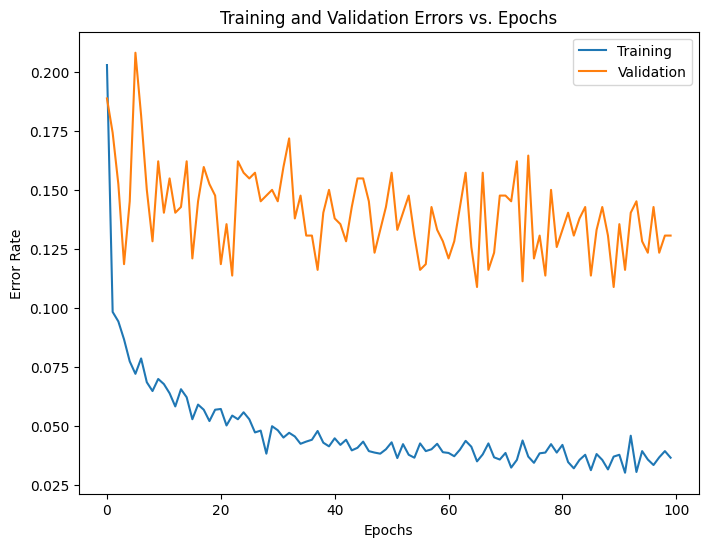

In [14]:
plot_history(ResNet50_hist)

**We now train on processed and augmented images**

In [17]:
# Obtain processed and augmented images 
data_path = "../data/Jute_Pest_Processed"
train_ds, val_ds, test_ds, classes, num_classes = create_ds(data_path)
configs = models["ResNet50"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
ResNet50_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_model.summary()

Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,827,089 (106.15 MB)

 Trainable params: 4,235,281 (16.16 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [18]:
filepath = "../Transfer_Models/best_ResNet50_2.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

ResNet50_hist2 = ResNet50_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4709 - loss: 2.3651

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 207s 152ms/step - accuracy: 0.4710 - loss: 2.3648 - val_accuracy: 0.6998 - val_loss: 1.9100
Epoch 2/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6786 - loss: 1.5444 - val_accuracy: 0.7215 - val_loss: 2.0216
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7078 - loss: 1.5691 - val_accuracy: 0.7482 - val_loss: 2.0089
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7394 - loss: 1.5736 - val_accuracy: 0.7094 - val_loss: 2.3885
Epoch 5/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7472 - loss: 1.6585 - val_accuracy: 0.7312 - val_loss: 2.3279
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7642 - loss: 1.6518 - val_accuracy: 0.8232 - val_loss: 1.9740
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7774 - loss: 1.6329 - val_accuracy: 0.7506 - val_loss: 2.4161
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7740 - loss: 1

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8566 - loss: 1.2212 - val_accuracy: 0.7869 - val_loss: 1.8324
Epoch 30/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8398 - loss: 1.2197 - val_accuracy: 0.7918 - val_loss: 1.9232
Epoch 31/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8548 - loss: 1.1812 - val_accuracy: 0.7724 - val_loss: 1.9440
Epoch 32/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8631 - loss: 1.1357 - val_accuracy: 0.7337 - val_loss: 2.2109
Epoch 33/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8562 - loss: 1.1389 - val_accuracy: 0.7724 - val_loss: 1.9147
Epoch 34/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8611 - loss: 1.1121

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8610 - loss: 1.1122 - val_accuracy: 0.8063 - val_loss: 1.6616
Epoch 35/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8581 - loss: 1.1249 - val_accuracy: 0.7409 - val_loss: 2.0062
Epoch 36/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8641 - loss: 1.0764 - val_accuracy: 0.7893 - val_loss: 1.8288
Epoch 37/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8632 - loss: 1.0814 - val_accuracy: 0.7700 - val_loss: 1.9728
Epoch 38/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8605 - loss: 1.0601 - val_accuracy: 0.7627 - val_loss: 2.0664
Epoch 39/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8569 - loss: 1.0541 - val_accuracy: 0.7869 - val_loss: 1.7062
Epoch 40/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8551 - loss: 1.0536 - val_accuracy: 0.8015 - val_loss: 1.7303
Epoch 41/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8543 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8717 - loss: 0.9955 - val_accuracy: 0.8111 - val_loss: 1.5231
Epoch 44/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8587 - loss: 1.0041 - val_accuracy: 0.7990 - val_loss: 1.6559
Epoch 45/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8704 - loss: 0.9750 - val_accuracy: 0.7966 - val_loss: 1.6039
Epoch 46/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8601 - loss: 0.9864 - val_accuracy: 0.7385 - val_loss: 2.0151
Epoch 47/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8617 - loss: 0.9886 - val_accuracy: 0.7772 - val_loss: 1.8423
Epoch 48/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8579 - loss: 0.9945 - val_accuracy: 0.7482 - val_loss: 1.9242
Epoch 49/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8741 - loss: 0.9391 - val_accuracy: 0.7700 - val_loss: 1.7433
Epoch 50/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8697 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8699 - loss: 0.9115 - val_accuracy: 0.7990 - val_loss: 1.5085
Epoch 59/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8667 - loss: 0.8911 - val_accuracy: 0.8015 - val_loss: 1.5677
Epoch 60/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8863 - loss: 0.8514 - val_accuracy: 0.7676 - val_loss: 1.6050
Epoch 61/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8714 - loss: 0.8918 - val_accuracy: 0.7676 - val_loss: 1.6830
Epoch 62/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8644 - loss: 0.9086 - val_accuracy: 0.7772 - val_loss: 1.5673
Epoch 63/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8717 - loss: 0.8712 - val_accuracy: 0.7797 - val_loss: 1.5579
Epoch 64/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8723 - loss: 0.8918

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8723 - loss: 0.8917 - val_accuracy: 0.7942 - val_loss: 1.4426
Epoch 65/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8768 - loss: 0.8525 - val_accuracy: 0.7554 - val_loss: 1.6827
Epoch 66/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8724 - loss: 0.8607 - val_accuracy: 0.7458 - val_loss: 1.6332
Epoch 67/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8804 - loss: 0.8462 - val_accuracy: 0.7966 - val_loss: 1.5359
Epoch 68/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8838 - loss: 0.8135 - val_accuracy: 0.7942 - val_loss: 1.5331
Epoch 69/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8844 - loss: 0.8250 - val_accuracy: 0.7845 - val_loss: 1.5337
Epoch 70/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8760 - loss: 0.8448

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8760 - loss: 0.8448 - val_accuracy: 0.8063 - val_loss: 1.4207
Epoch 71/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8797 - loss: 0.8247 - val_accuracy: 0.7869 - val_loss: 1.5840
Epoch 72/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8683 - loss: 0.8636 - val_accuracy: 0.7797 - val_loss: 1.5254
Epoch 73/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8779 - loss: 0.8219 - val_accuracy: 0.7918 - val_loss: 1.4502
Epoch 74/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8829 - loss: 0.8147 - val_accuracy: 0.7893 - val_loss: 1.5395
Epoch 75/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8828 - loss: 0.8232 - val_accuracy: 0.7966 - val_loss: 1.4390
Epoch 76/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8786 - loss: 0.8294 - val_accuracy: 0.7845 - val_loss: 1.5414
Epoch 77/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8827 - lo

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8881 - loss: 0.7800 - val_accuracy: 0.8015 - val_loss: 1.3744
Epoch 88/100
1285/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8792 - loss: 0.8052

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8792 - loss: 0.8052 - val_accuracy: 0.8063 - val_loss: 1.3542
Epoch 89/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8789 - loss: 0.8022 - val_accuracy: 0.7966 - val_loss: 1.4686
Epoch 90/100
1283/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8817 - loss: 0.7823

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8817 - loss: 0.7823 - val_accuracy: 0.8087 - val_loss: 1.3402
Epoch 91/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8885 - loss: 0.7681 - val_accuracy: 0.8063 - val_loss: 1.3958
Epoch 92/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8769 - loss: 0.7867 - val_accuracy: 0.7869 - val_loss: 1.4825
Epoch 93/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8845 - loss: 0.7672 - val_accuracy: 0.8136 - val_loss: 1.3793
Epoch 94/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8821 - loss: 0.7785 - val_accuracy: 0.7990 - val_loss: 1.3830
Epoch 95/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8850 - loss: 0.7639 - val_accuracy: 0.8015 - val_loss: 1.3410
Epoch 96/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8862 - loss: 0.7743 - val_accuracy: 0.8111 - val_loss: 1.3490
Epoch 97/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8825 - lo

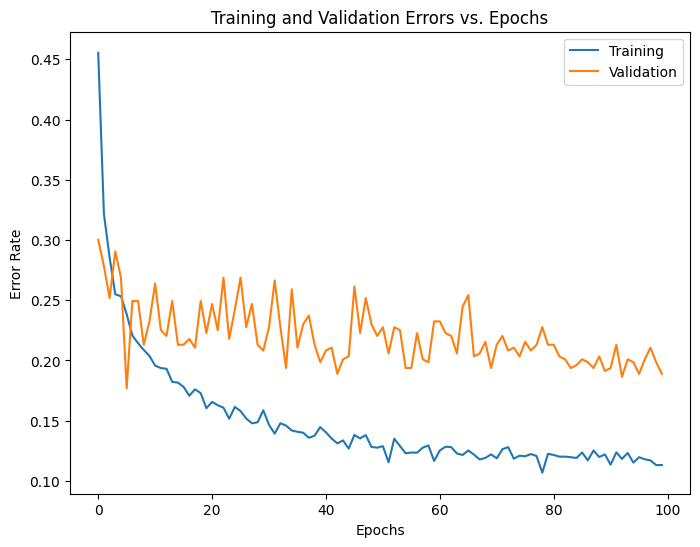

In [19]:
plot_history(ResNet50_hist2)

The ResNet50 model trained on the raw images outperformed the model trained on the processed and augmented images on both the training and validation sets based on accuracy (or error rate). 

Raw images:
* Train accuracy: ~90-97%
* Validation accuracy: ~80-89%

Processed and augmented images:
* Train accuracy: ~70-90%
* Validation accuracy: ~72-80%

This suggests that the additional preprocessing and augmentation steps did not improve model generalization in this setting and may have removed or distorted informative features present in the original images. It may be indicative that we shouldn't use all six augmenting techniques on each image, perhaps just a couple augmenting methods for each image. Nonetheless, we move forward with training the remaining models on the processed and augmented images. 

### ResNet101

In [20]:
configs = models["ResNet101"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
ResNet101_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

ResNet101_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ResNet101_model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ResNet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,897,553 (178.90 MB)

 Trainable params: 4,235,281 (16.16 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [21]:
filepath = "../Transfer_Models/best_ResNet101.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

ResNet101_hist = ResNet101_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4963 - loss: 2.2907

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - accuracy: 0.4964 - loss: 2.2904 - val_accuracy: 0.7482 - val_loss: 1.4246
Epoch 2/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6939 - loss: 1.4646 - val_accuracy: 0.7554 - val_loss: 1.5882
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7446 - loss: 1.4176 - val_accuracy: 0.7700 - val_loss: 1.6679
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7593 - loss: 1.4887 - val_accuracy: 0.8087 - val_loss: 1.8055
Epoch 5/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7763 - loss: 1.5531 - val_accuracy: 0.7627 - val_loss: 2.1149
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7846 - loss: 1.5936 - val_accuracy: 0.8063 - val_loss: 1.9423
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8002 - loss: 1.5800 - val_accuracy: 0.7579 - val_loss: 2.2320
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7991 - los

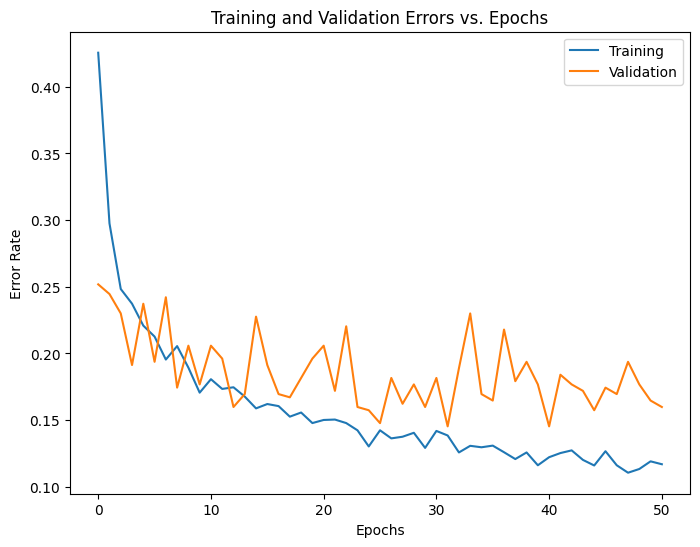

In [22]:
plot_history(ResNet101_hist)

### EfficientNetB0

In [23]:
configs = models["EfficientNetB0"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
EfficientNetB0_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

EfficientNetB0_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB0_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 1280)           │     1,639,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │        21,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716,148 (21.81 MB)

 Trainable params: 1,664,017 (6.35 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [24]:
filepath = "../Transfer_Models/best_EfficientNetB0.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

EfficientNetB0_hist = EfficientNetB0_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6157 - loss: 1.5445

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 90s 42ms/step - accuracy: 0.6158 - loss: 1.5442 - val_accuracy: 0.7942 - val_loss: 1.0424
Epoch 2/100
1283/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8044 - loss: 0.8653

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8044 - loss: 0.8654 - val_accuracy: 0.8305 - val_loss: 0.9927
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8211 - loss: 0.8927 - val_accuracy: 0.8015 - val_loss: 1.2955
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8418 - loss: 0.9045 - val_accuracy: 0.8910 - val_loss: 1.0176
Epoch 5/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8571 - loss: 0.9282 - val_accuracy: 0.8547 - val_loss: 1.1533
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8641 - loss: 0.9493 - val_accuracy: 0.8959 - val_loss: 1.1773
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8759 - loss: 0.9430 - val_accuracy: 0.8571 - val_loss: 1.3214
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8847 - loss: 0.9550 - val_accuracy: 0.8281 - val_loss: 1.6533
Epoch 9/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8795 - loss: 0.99

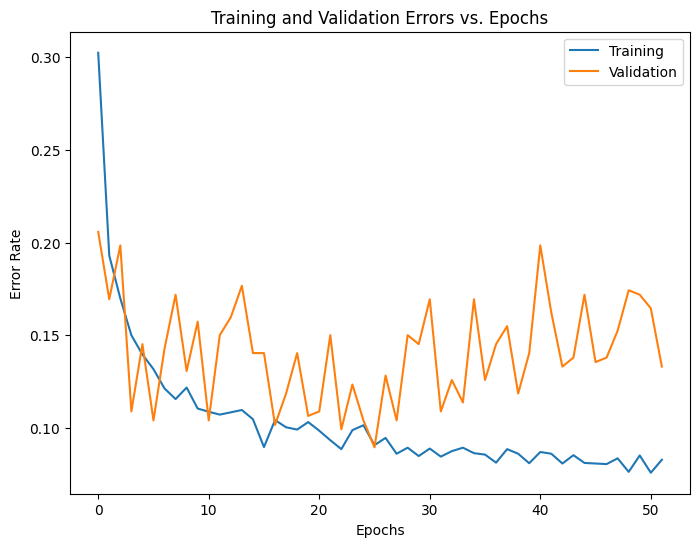

In [25]:
plot_history(EfficientNetB0_hist)

### VGG16

In [26]:
configs = models["VGG16"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
VGG16_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
VGG16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │         8,721 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,988,113 (57.18 MB)

 Trainable params: 272,401 (1.04 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [27]:
filepath = "../Transfer_Models/best_VGG16.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

VGG16_hist = VGG16_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4322 - loss: 1.9713

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.4322 - loss: 1.9711 - val_accuracy: 0.6998 - val_loss: 1.3304
Epoch 2/100
1281/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6462 - loss: 1.2130

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6462 - loss: 1.2130 - val_accuracy: 0.7385 - val_loss: 1.2531
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6912 - loss: 1.0958 - val_accuracy: 0.7482 - val_loss: 1.3340
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7229 - loss: 1.0210 - val_accuracy: 0.7627 - val_loss: 1.3395
Epoch 5/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7290 - loss: 1.0056

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7290 - loss: 1.0056 - val_accuracy: 0.7918 - val_loss: 1.2399
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7500 - loss: 0.9894 - val_accuracy: 0.7385 - val_loss: 1.3470
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7782 - loss: 0.8975 - val_accuracy: 0.7482 - val_loss: 1.4323
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7734 - loss: 0.9078 - val_accuracy: 0.7433 - val_loss: 1.5220
Epoch 9/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7757 - loss: 0.9330 - val_accuracy: 0.7337 - val_loss: 1.6966
Epoch 10/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7852 - loss: 0.9020 - val_accuracy: 0.7772 - val_loss: 1.4782
Epoch 11/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7918 - loss: 0.9019 - val_accuracy: 0.7748 - val_loss: 1.3877
Epoch 12/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8006 - loss: 0.8875 - 

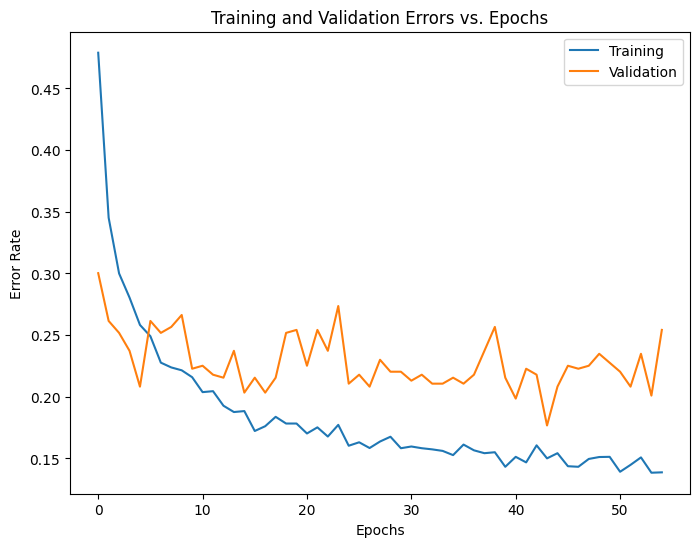

In [28]:
plot_history(VGG16_hist)

### DenseNet201

In [29]:
configs = models["DenseNet201"]
base_cls = configs["class"]
channel_shape = configs["channels"]

# Build model
DenseNet201_model = build_transfer_model(
    base_cls,
    channels=channel_shape,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=17,
    l2_reg=L2_REG,
    dropout_rate=DROPOUT_RATE
)

DenseNet201_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
DenseNet201_model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseLayer (Dense)              │ (None, 1920)           │     3,688,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm (BatchNormalization)  │ (None, 1920)           │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU (ReLU)                     │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 17)             │        32,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,050,641 (84.12 MB)

 Trainable params: 3,724,817 (14.21 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [30]:
filepath = "../Transfer_Models/best_DenseNet201.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=PATIENCE,
                          verbose=1,
                          restore_best_weights=True)

DenseNet201_hist = DenseNet201_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint, earlystop])

Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1366 - loss: 3.4868

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 151s 78ms/step - accuracy: 0.1367 - loss: 3.4866 - val_accuracy: 0.2155 - val_loss: 3.1793
Epoch 2/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2137 - loss: 2.9511

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.2137 - loss: 2.9511 - val_accuracy: 0.2349 - val_loss: 2.9353
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.2438 - loss: 2.7822 - val_accuracy: 0.2833 - val_loss: 3.1514
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.2547 - loss: 2.7567 - val_accuracy: 0.2809 - val_loss: 2.9475
Epoch 5/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2900 - loss: 2.6624

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.2900 - loss: 2.6624 - val_accuracy: 0.2615 - val_loss: 2.9008
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.2873 - loss: 2.6587 - val_accuracy: 0.2518 - val_loss: 3.2367
Epoch 7/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3016 - loss: 2.5838 - val_accuracy: 0.2712 - val_loss: 3.0960
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3110 - loss: 2.5484

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3110 - loss: 2.5484 - val_accuracy: 0.3680 - val_loss: 2.6130
Epoch 9/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3265 - loss: 2.5013 - val_accuracy: 0.2615 - val_loss: 2.8439
Epoch 10/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3353 - loss: 2.4547 - val_accuracy: 0.2736 - val_loss: 2.7861
Epoch 11/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3365 - loss: 2.4290 - val_accuracy: 0.2809 - val_loss: 2.7000
Epoch 12/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3384 - loss: 2.4064 - val_accuracy: 0.2615 - val_loss: 2.8983
Epoch 13/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3572 - loss: 2.3354 - val_accuracy: 0.3002 - val_loss: 2.8528
Epoch 14/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3711 - loss: 2.3129 - val_accuracy: 0.3051 - val_loss: 2.7219
Epoch 15/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3654

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3818 - loss: 2.2256 - val_accuracy: 0.2736 - val_loss: 2.6064
Epoch 20/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3949 - loss: 2.1797 - val_accuracy: 0.2760 - val_loss: 2.7011
Epoch 21/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3813 - loss: 2.1619

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3813 - loss: 2.1619 - val_accuracy: 0.3220 - val_loss: 2.5563
Epoch 22/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4090 - loss: 2.1217 - val_accuracy: 0.3027 - val_loss: 2.6221
Epoch 23/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.4030 - loss: 2.1308 - val_accuracy: 0.3002 - val_loss: 2.6287
Epoch 24/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4080 - loss: 2.0994

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4080 - loss: 2.0994 - val_accuracy: 0.2833 - val_loss: 2.5296
Epoch 25/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.4102 - loss: 2.1254 - val_accuracy: 0.3390 - val_loss: 2.6654
Epoch 26/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4200 - loss: 2.0863

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4200 - loss: 2.0863 - val_accuracy: 0.3245 - val_loss: 2.5220
Epoch 27/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4167 - loss: 2.1036 - val_accuracy: 0.3317 - val_loss: 2.6106
Epoch 28/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4170 - loss: 2.0652

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.4170 - loss: 2.0652 - val_accuracy: 0.3366 - val_loss: 2.5196
Epoch 29/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.4291 - loss: 2.0573 - val_accuracy: 0.3390 - val_loss: 2.5679
Epoch 30/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4276 - loss: 2.0596 - val_accuracy: 0.3220 - val_loss: 2.5565
Epoch 31/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4393 - loss: 2.0216

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4392 - loss: 2.0216 - val_accuracy: 0.3269 - val_loss: 2.4705
Epoch 32/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4473 - loss: 2.0223 - val_accuracy: 0.3341 - val_loss: 2.5162
Epoch 33/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4256 - loss: 2.0157 - val_accuracy: 0.3099 - val_loss: 2.5346
Epoch 34/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4458 - loss: 1.9992 - val_accuracy: 0.3245 - val_loss: 2.6616
Epoch 35/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4381 - loss: 2.0114

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.4380 - loss: 2.0114 - val_accuracy: 0.3245 - val_loss: 2.4657
Epoch 36/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4430 - loss: 2.0127 - val_accuracy: 0.3801 - val_loss: 2.4811
Epoch 37/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4429 - loss: 1.9940 - val_accuracy: 0.3511 - val_loss: 2.4994
Epoch 38/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4405 - loss: 2.0191 - val_accuracy: 0.3438 - val_loss: 2.5682
Epoch 39/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4333 - loss: 1.9830

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.4333 - loss: 1.9830 - val_accuracy: 0.3414 - val_loss: 2.4574
Epoch 40/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.4494 - loss: 1.9850 - val_accuracy: 0.3027 - val_loss: 2.6231
Epoch 41/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4434 - loss: 1.9957 - val_accuracy: 0.3293 - val_loss: 2.6658
Epoch 42/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4489 - loss: 1.9798 - val_accuracy: 0.3535 - val_loss: 2.4610
Epoch 43/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4633 - loss: 1.9420

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.4633 - loss: 1.9420 - val_accuracy: 0.3584 - val_loss: 2.4090
Epoch 44/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.4634 - loss: 1.9275 - val_accuracy: 0.3511 - val_loss: 2.4533
Epoch 45/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4467 - loss: 1.9551 - val_accuracy: 0.3293 - val_loss: 2.5737
Epoch 46/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4585 - loss: 1.9413 - val_accuracy: 0.3390 - val_loss: 2.5820
Epoch 47/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4634 - loss: 1.9611 - val_accuracy: 0.3511 - val_loss: 2.5721
Epoch 48/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4643 - loss: 1.9433 - val_accuracy: 0.2978 - val_loss: 2.6031
Epoch 49/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.4569 - loss: 1.9439 - val_accuracy: 0.3511 - val_loss: 2.5623
Epoch 50/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.461

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4662 - loss: 1.9173 - val_accuracy: 0.3680 - val_loss: 2.3933
Epoch 59/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4802 - loss: 1.8929 - val_accuracy: 0.3487 - val_loss: 2.5969
Epoch 60/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4597 - loss: 1.9186 - val_accuracy: 0.3535 - val_loss: 2.7237
Epoch 61/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.4784 - loss: 1.9067 - val_accuracy: 0.3414 - val_loss: 2.5873
Epoch 62/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4715 - loss: 1.9041 - val_accuracy: 0.3705 - val_loss: 2.4967
Epoch 63/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4612 - loss: 1.9190 - val_accuracy: 0.3487 - val_loss: 2.6538
Epoch 64/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4665 - loss: 1.9165 - val_accuracy: 0.3293 - val_loss: 2.6240
Epoch 65/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.483

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4733 - loss: 1.9062 - val_accuracy: 0.3923 - val_loss: 2.3896
Epoch 75/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4718 - loss: 1.8894 - val_accuracy: 0.3801 - val_loss: 2.4910
Epoch 76/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4849 - loss: 1.8816 - val_accuracy: 0.3705 - val_loss: 2.5868
Epoch 77/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4702 - loss: 1.8951 - val_accuracy: 0.3269 - val_loss: 2.7583
Epoch 78/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4776 - loss: 1.9076 - val_accuracy: 0.3245 - val_loss: 2.6292
Epoch 79/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4765 - loss: 1.9048 - val_accuracy: 0.3729 - val_loss: 2.5284
Epoch 80/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.4709 - loss: 1.9100 - val_accuracy: 0.3366 - val_loss: 2.6273
Epoch 81/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.482

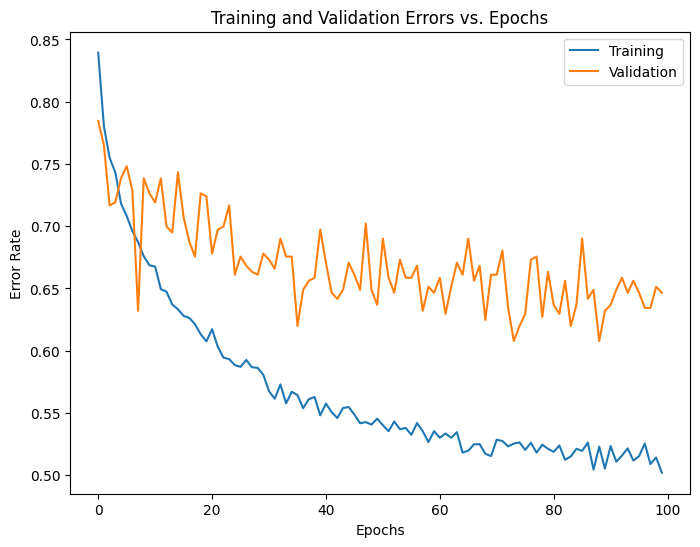

In [40]:
plot_history(DenseNet201_hist)

## Results

We report training, validation, and test Precision, Recall, AUC, and F1 score for the 5 models.

In [32]:
def get_pred(model, dataset):
    y_true = []
    y_pred = []
    y_prob = []

    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0)
        y_prob.append(probs)

        y_true.append(np.argmax(y_batch.numpy(), axis=1))
        y_pred.append(np.argmax(probs, axis=1))

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)

    return y_true, y_pred, y_prob

def compute_metrics(y_true, y_pred, y_prob):
    metrics = {}

    metrics["Precision"] = precision_score(
        y_true, y_pred, average="macro", zero_division=0
    )

    metrics["Recall"] = recall_score(
        y_true, y_pred, average="macro", zero_division=0
    )

    metrics["F1"] = f1_score(
        y_true, y_pred, average="macro", zero_division=0
    )

    metrics["AUC"] = roc_auc_score(
        y_true,
        y_prob,
        multi_class="ovr",
        average="macro"
    )

    return metrics

def evaluate_model(model, train_ds, val_ds, test_ds):
    results = {}

    for split_name, ds in zip(
        ["Train", "Validation", "Test"],
        [train_ds, val_ds, test_ds]
    ):
        y_true, y_pred, y_prob = get_pred(model, ds)
        results[split_name] = compute_metrics(y_true, y_pred, y_prob)

    return results


In [33]:
models = {
    "ResNet50": ResNet50_model,
    "ResNet101": ResNet101_model,
    "EfficientNetB0": EfficientNetB0_model,
    "VGG16": VGG16_model,
    "DenseNet201": DenseNet201_model
}

results = []

for model_name, model in models.items():
    metrics = evaluate_model(model, train_ds, val_ds, test_ds)

    for split in ["Train", "Validation", "Test"]:
        row = {
            "Model": model_name,
            "Split": split,
            **metrics[split]
        }
        results.append(row)


In [34]:
results_df = pd.DataFrame(results)
results_df.round(4)

,Model,Split,Precision,Recall,F1,AUC
0,ResNet50,Train,0.9899,0.9915,0.9906,1.0000
1,ResNet50,Validation,0.7358,0.7824,0.7501,0.9742
2,ResNet50,Test,0.9008,0.8836,0.8772,0.9945
3,ResNet101,Train,0.8435,0.8218,0.8244,0.9907
4,ResNet101,Validation,0.7062,0.6822,0.6487,0.9755
5,ResNet101,Test,0.8752,0.8503,0.8496,0.9921
6,EfficientNetB0,Train,0.9507,0.9436,0.9465,0.9990
7,EfficientNetB0,Validation,0.7778,0.8192,0.7843,0.9876
8,EfficientNetB0,Test,0.9350,0.9299,0.9262,0.9953
9,VGG16,Train,0.9225,0.9175,0.9180,0.9972


### ResNet50 Results

In [35]:
results_df[results_df["Model"]=="ResNet50"]


,Model,Split,Precision,Recall,F1,AUC
0,ResNet50,Train,0.989899,0.991524,0.990618,0.999985
1,ResNet50,Validation,0.735819,0.782418,0.750099,0.974205
2,ResNet50,Test,0.900782,0.883645,0.877204,0.994539


### ResNet101 Results

In [36]:
results_df[results_df["Model"]=="ResNet101"]

,Model,Split,Precision,Recall,F1,AUC
3,ResNet101,Train,0.843477,0.821756,0.824368,0.990744
4,ResNet101,Validation,0.706201,0.682175,0.648674,0.975502
5,ResNet101,Test,0.875239,0.850325,0.849613,0.992122


### EfficientNetB0 Results

In [37]:
results_df[results_df["Model"]=="EfficientNetB0"]

,Model,Split,Precision,Recall,F1,AUC
6,EfficientNetB0,Train,0.950671,0.943550,0.946466,0.998963
7,EfficientNetB0,Validation,0.777763,0.819154,0.784338,0.987600
8,EfficientNetB0,Test,0.935000,0.929902,0.926192,0.995318


### VGG16 Results

In [38]:
results_df[results_df["Model"]=="VGG16"]

,Model,Split,Precision,Recall,F1,AUC
9,VGG16,Train,0.922478,0.917515,0.918037,0.997234
10,VGG16,Validation,0.721385,0.765517,0.727652,0.948685
11,VGG16,Test,0.833120,0.808601,0.804003,0.989989


### DenseNet201 Results

In [39]:
results_df[results_df["Model"]=="DenseNet201"]

,Model,Split,Precision,Recall,F1,AUC
12,DenseNet201,Train,0.675835,0.645800,0.643535,0.954564
13,DenseNet201,Validation,0.327931,0.338664,0.304710,0.788657
14,DenseNet201,Test,0.533257,0.498179,0.477152,0.908460


Out of the 5 models, EfficientNetB0 demonstrated the strongest overall performance, achieving the highest validation and test precision, recall, AUC, and F1 scores. ResNet50 achieves near-perfect training performance but shows a larger train-validation gap (and achieved lower test metrics than EfficientNetB0), indicating that ResNet50 overfitted to the training data. ResNet101 does not outperform ResNet50 despite increased depth. VGG16 performs reasonably but lags behind EfficientNetB0 in both validation and test metrics. DenseNet201 consistently underperformed across all splits. In conclusion, EfficientNetB0 provides the best balance between performance and generalization and is the most reliable model for this task. 

## References

https://www.geeksforgeeks.org/computer-vision/python-opencv-getrotationmatrix2d-function/

https://www.geeksforgeeks.org/machine-learning/image-enhancement-techniques-using-opencv-python/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://keras.io/api/models/model_training_apis/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense